In [2]:
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras.datasets import mnist
from emnist import extract_training_samples
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
# from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import sys
import os

sys.path.insert(1, os.path.join(sys.path[0], '../../..'))

from utils import *

%matplotlib inline
%config Completer.use_jedi = False

tf.config.list_physical_devices('GPU')
tf.compat.v1.enable_eager_execution()

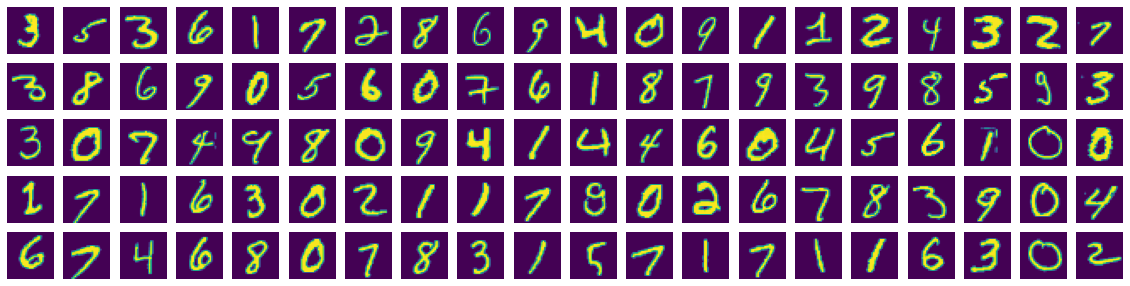

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
show_dataset(x_train)

In [4]:
num_classes = 10 

mean = np.mean(x_train,axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = utils.to_categorical(y_train, num_classes) 
y_test = utils.to_categorical(y_test, num_classes) 

In [5]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [6]:
results = {}

# float64 - h5

In [9]:
model = tf.keras.models.load_model("vanilla_mnist.h5")

In [11]:
results['base'] = full_evaluate2(model.predict(x_test), y_test)

In [13]:
results['base']['size (kb)'] = os.stat('vanilla_mnist.h5').st_size//1024

# float32 - tflite

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("vanilla_mnist_float32.tflite", "wb") as f:
    f.write(tflite_model)  

INFO:tensorflow:Assets written to: /tmp/tmpp2_i_09n/assets


INFO:tensorflow:Assets written to: /tmp/tmpp2_i_09n/assets


In [15]:
preds = get_tflite_preds("vanilla_mnist_float32.tflite", x_test.astype('float32'))

preds = np.array(preds)

preds = preds.reshape(-1,10)

In [16]:
results['float32'] = full_evaluate2(preds, y_test)

In [17]:
results['float32']['size (kb)'] = os.stat('vanilla_mnist_float32.tflite').st_size//1024

In [18]:
pprint(results['float32'])

{'accuracy_score': 0.9956,
 'f1_score_macro': 0.9955861598397971,
 'f1_score_weighted': 0.9956003854113596,
 'size (kb)': 1714}


# float16 - tflite optimized

In [19]:
def representative_dataset_gen():
    for i in range(10):
        yield [x_test.astype('float32')[i:i+1]]

In [20]:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.experimental_new_converter = True
    converter.experimental_new_quantizer = True
    converter.representative_dataset = representative_dataset_gen
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#     converter.inference_input_type = tf.int8
#     converter.inference_output_type = tf.int8
    converter.target_spec.supported_ops = [tf.float16]

    tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpd52s3xnp/assets


INFO:tensorflow:Assets written to: /tmp/tmpd52s3xnp/assets


In [21]:
with open("vanilla_mnist_float16.tflite", "wb") as f:
    f.write(tflite_model)  

In [22]:
preds = get_tflite_preds("vanilla_mnist_float16.tflite", (x_test).astype(np.float32))

In [23]:
preds = np.array(preds)

preds = preds.reshape(-1,10)

In [25]:
results['float16'] = full_evaluate2(preds, y_test)

In [26]:
results['float16']['size (kb)'] = os.stat('vanilla_mnist_float16.tflite').st_size//1024

In [27]:
pprint(results['float16'])

{'accuracy_score': 0.9955,
 'f1_score_macro': 0.9954941412797655,
 'f1_score_weighted': 0.9955004827277726,
 'size (kb)': 452}


# save results

In [28]:
import json

In [29]:
pprint(results)

{'base': {'accuracy_score': 0.9956,
          'f1_score_macro': 0.9955861598397971,
          'f1_score_weighted': 0.9956003854113596,
          'size (kb)': 5271},
 'float16': {'accuracy_score': 0.9955,
             'f1_score_macro': 0.9954941412797655,
             'f1_score_weighted': 0.9955004827277726,
             'size (kb)': 452},
 'float32': {'accuracy_score': 0.9956,
             'f1_score_macro': 0.9955861598397971,
             'f1_score_weighted': 0.9956003854113596,
             'size (kb)': 1714}}


In [30]:
with open('results_quantization.json', 'w', encoding ='utf8') as json_file:
    json.dump(results, json_file, ensure_ascii = True)